In [2]:
import os, sys
import numpy as np
import plotly.express as px
sys.path.append('../')

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2
from onsstove.onsstove import OnSSTOVE, DataProcessor
from onsstove.layer import RasterLayer, VectorLayer
from onsstove.raster import interpolate
import time

start = time.time()

# Data processing

In [ ]:
data = DataProcessor(project_crs=3857, cell_size=(1000, 1000))
output_directory = 'results'
data.output_directory = output_directory

In [ ]:
adm_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Administrative boundaries\Admin lvl 0.shp"
data.add_mask_layer(category='Administrative', name='Country_boundaries', layer_path=adm_path)

In [ ]:
pop_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Demand\Population\HRSL\population_npl_2018-10-01_geotiff\population_npl_2018-10-01.tif"
data.add_layer(category='Demographics', name='Population', layer_path=pop_path, layer_type='raster', base_layer=True, resample='sum')

forest_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Forest cover\Global Forest Cover Change (GFCC).tif"
data.add_layer(category='Biomass', name='Forest', layer_path=forest_path, layer_type='raster', resample='nearest')

friction_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Walking friction\2020_walking_only_friction_surface.geotiff"
data.add_layer(category='Biomass', name='Friction', layer_path=friction_path, layer_type='raster', resample='average')

In [ ]:
hv_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\HV-network\Existing_transmission_lines.geojson"
data.add_layer(category='Electricity', name='HV_lines', layer_path=hv_path, layer_type='vector')

ntl_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Night Time Lights\nighttime lights.tif"
data.add_layer(category='Electricity', name='Night_time_lights', layer_path=ntl_path, layer_type='raster', resample='average')

In [ ]:
lpg_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\LPG\Nepal_Gas_12Jun2021_Final4.shp"
data.add_layer(category='LPG', name='Suppliers', layer_path=lpg_path, layer_type='vector')

friction_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Motorized friction\2020_motorized_friction_surface.geotiff"
data.add_layer(category='LPG', name='Friction', layer_path=friction_path, layer_type='raster', resample='average')

In [ ]:
ghs_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Urban - Rural divide\GHS.tif"
data.add_layer(category='Demographics', name='Urban_rural_divide', layer_path=ghs_path, layer_type='raster', resample='nearest')

In [ ]:
data.mask_layers(datasets='all')

In [ ]:
mv_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\MV-network\Nepal_DL0.shp"
data.add_layer(category='Electricity', name='MV_lines', layer_path=mv_path, layer_type='vector')

In [ ]:
data.reproject_layers(datasets='all')
data.align_layers(datasets='all')

In [ ]:
end = time.time()

diff = end - start
print('Execution time:', str(str(int(diff//60))) + ' min ' + str(int((diff)%60)) + ' sec')

## 1. Create an OnSSTOVE model

In [210]:
nepal = OnSSTOVE()
output_directory = 'results'
nepal.output_directory = output_directory

## 2. Read the scenario data

In [211]:
path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\OnSSTOVE cases\NP_test_file_social_specs.csv"
nepal.read_scenario_data(path, delimiter=',')

## 3. Read the cooking technologies data

In [212]:
path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\OnSSTOVE cases\NP_test_file_tech_specs.csv"
nepal.read_tech_data(path, delimiter=',')

## 4. Add a country mask layer

In [213]:
path = os.path.join(output_directory, 'Administrative', 'Country_boundaries', 'Country_boundaries.geojson')
mask_layer = VectorLayer('admin', 'adm_0', layer_path=path)
nepal.mask_layer = mask_layer

## 5. Add a population base layer

In [214]:
path = os.path.join(output_directory, 'Demographics', 'Population', 'Population.tif')
nepal.add_layer(category='Demographics', name='Population', layer_path=path, layer_type='raster', base_layer=True)
nepal.population_to_dataframe()

In [215]:
path = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Administrative boundaries\Admin lvl 1.shp"
nepal.add_admin_names(path, 'ADM1_EN')

In [216]:
nepal.gdf

,geometry,Pop,ADM1_EN
0,POINT (9090104.530 3543192.836),31.171455,Karnali
1,POINT (9090104.530 3536192.836),46.757183,Karnali
2,POINT (9083104.530 3535192.836),5.517799,Karnali
3,POINT (9084104.530 3535192.836),15.585728,Karnali
4,POINT (9064104.530 3534192.836),15.585728,Karnali
...,...,...,...
96717,POINT (9724104.530 3044192.836),98.039602,Province 1
96718,POINT (9797104.530 3044192.836),536.486856,Province 1
96719,POINT (9798104.530 3044192.836),315.580504,Province 1
96720,POINT (9722104.530 3043192.836),642.881959,Province 1


## 6. Calibrate population and urban/rural split

In [217]:
nepal.calibrate_current_pop()

# path = os.path.join(output_directory, 'Demographics', 'Urban_rural_divide', 'Urban_rural_divide.tif')
ghs_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Urban - Rural divide\GHS.tif"
nepal.calibrate_urban_current_and_future_GHS(ghs_path)

## 7. Calculate parameters of base fuel (Biomass)

### 7.1. Health costs

In [218]:
# Calculate relative risk for each disease for the base fuel
rr_0_alri, rr_0_copd, rr_0_ihd, rr_0_lc = nepal.base_fuel.relative_risk()

# Calculate the Population Atributable Factor (PAF) for each disease for the base fuel
paf_0_alri = nepal.base_fuel.paf(rr_0_alri, 1 - nepal.specs['clean_cooking_access'])
paf_0_copd = nepal.base_fuel.paf(rr_0_copd, 1 - nepal.specs['clean_cooking_access'])
paf_0_ihd  = nepal.base_fuel.paf(rr_0_ihd, 1 - nepal.specs['clean_cooking_access'])
paf_0_lc = nepal.base_fuel.paf(rr_0_lc, 1 - nepal.specs['clean_cooking_access'])

### 7.2. Carbon emissions and related costs

In [219]:
nepal.base_fuel.carb(nepal.specs, nepal.gdf)

### 7.3. Time for travelling, collecting fuel, and cooking

In [239]:
# paths to GIS layers
nepal.base_fuel.friction_path = os.path.join(output_directory, 'Biomass', 'Friction', 'Friction.tif')
nepal.base_fuel.forest_path = os.path.join(output_directory, 'Biomass', 'Forest', 'Forest.tif')

# Calculate total time
nepal.base_fuel.total_time(nepal)

## 8. Add wealth index GIS data

In [240]:
# wealth_index = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Demand\Wealth Index\npl_relative_wealth_index.csv"
# nepal.extract_wealth_index(wealth_index, file_type="csv", 
#                      x_column="longitude", y_column="latitude", wealth_column="rwi")

wealth_index = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Demand\Wealth Index\Wealth index 2011.tif"
nepal.extract_wealth_index(wealth_index, file_type="raster")

### 8.1. Calculate value of time

In [241]:
# Based on wealth index, minimum wage and a lower an upper range for cost of oportunity
nepal.get_value_of_time()

## 9. Read electricity network GIS layers

In [242]:
# Read MV lines
path = os.path.join(output_directory, 'Electricity', 'MV_lines', 'MV_lines.geojson')
mv_lines = VectorLayer('Electricity', 'MV_lines', layer_path=path)

# Read HV lines
path = os.path.join(output_directory, 'Electricity', 'HV_lines', 'HV_lines.geojson')
hv_lines = VectorLayer('Electricity', 'HV_lines', layer_path=path)

### 9.1. Calculate distance to electricity infrastructure 

In [243]:
nepal.distance_to_electricity(hv_lines=hv_lines, mv_lines=mv_lines)

## 10. Add night time lights data

In [244]:
path = os.path.join(output_directory, 'Electricity', 'Night_time_lights', 'Night_time_lights.tif')
ntl = RasterLayer('Electricity', 'Night_time_lights', layer_path=path)

nepal.raster_to_dataframe(ntl.layer, name='Night_lights', method='read')

## 11. Calibrate current electrified population

In [245]:
nepal.current_elec()
nepal.final_elec()

print('Calibrated grid electrified population fraction:', nepal.gdf['Elec_pop_calib'].sum() / nepal.gdf['Calibrated_pop'].sum())

Calibrated grid electrified population fraction: 0.7199910437673593


## 12. Adding GIS data for LPG supply

In [246]:
nepal.techs['LPG'].lpg_path = os.path.join(output_directory, 'LPG', 'Suppliers', 'Suppliers.geojson')
nepal.techs['LPG'].friction_path = os.path.join(output_directory, 'LPG', 'Friction', 'Friction.tif')

nepal.techs['LPG'].add_travel_time(nepal)

## 13. Adding GIS data for Improved Biomass collected (ICS biomass)

In [247]:
nepal.techs['Collected_Improved_Biomass'].friction_path = os.path.join(output_directory, 'Biomass', 'Friction', 'Friction.tif')
nepal.techs['Collected_Improved_Biomass'].forest_path = os.path.join(output_directory, 'Biomass', 'Forest', 'Forest.tif')

## 14. Calculate benefits and costs of each technology

In [248]:
names = ['Electricity', 'Collected_Traditional_Biomass', 'Collected_Improved_Biomass', 'LPG']
techs = [nepal.techs[name] for name in names]

# Loop through each technology and calculate all benefits and costs
for tech in techs:
    print(f'Calculating health benefits for {tech.name}...')
    tech.morbidity(nepal.specs, nepal.gdf, paf_0_alri, paf_0_copd, paf_0_lc, paf_0_ihd)
    tech.mortality(nepal.specs, nepal.gdf, paf_0_alri, paf_0_copd, paf_0_lc, paf_0_ihd)
    print(f'Calculating carbon emissions benefits for {tech.name}...')
    tech.carbon_emissions(nepal.specs, nepal.gdf, nepal.base_fuel.carbon)
    print(f'Calculating time saved benefits for {tech.name}...')
    tech.time_saved(nepal)
    print(f'Calculating costs for {tech.name}...')
    tech.discounted_om(nepal.gdf, nepal.specs)
    tech.discounted_inv(nepal.gdf, nepal.specs)
    tech.discounted_meals(nepal.gdf, nepal.specs)
    tech.discount_fuel_cost(nepal.gdf, nepal.specs, nepal.rows, nepal.cols)
    tech.salvage(nepal.gdf, nepal.specs)
    print(f'Calculating net benefit for {tech.name}...\n')
    tech.net_benefit(nepal.gdf)

Calculating health benefits for Electricity...
Calculating carbon emissions benefits for Electricity...
Calculating time saved benefits for Electricity...
Calculating costs for Electricity...
Calculating net benefit for Electricity...

Calculating health benefits for Collected_Traditional_Biomass...
Calculating carbon emissions benefits for Collected_Traditional_Biomass...
Calculating time saved benefits for Collected_Traditional_Biomass...
Calculating costs for Collected_Traditional_Biomass...
Calculating net benefit for Collected_Traditional_Biomass...

Calculating health benefits for Collected_Improved_Biomass...
Calculating carbon emissions benefits for Collected_Improved_Biomass...
Calculating time saved benefits for Collected_Improved_Biomass...
Calculating costs for Collected_Improved_Biomass...
Calculating net benefit for Collected_Improved_Biomass...

Calculating health benefits for LPG...
Calculating carbon emissions benefits for LPG...
Calculating time saved benefits for LPG

## 15. Getting the max benefit technology for each cell

In [249]:
nepal.maximum_net_benefit()

In [250]:
nepal.gdf

,geometry,Pop,ADM1_EN,Calibrated_pop,IsUrban,Households,relative_wealth,value_of_time,HV_lines_dist,MV_lines_dist,...,benefits_Collected_Traditional_Biomass,net_benefit_Collected_Traditional_Biomass,costs_Collected_Improved_Biomass,benefits_Collected_Improved_Biomass,net_benefit_Collected_Improved_Biomass,costs_LPG,benefits_LPG,net_benefit_LPG,max_benefit_tech,maximum_net_benefit
0,POINT (9090104.530 3543192.836),31.171455,Karnali,31.344224,11.0,5.498987,8.755903,0.032185,109.590149,40.521599,...,0.0,-0.166667,8.529318,88.359893,79.830575,292.824508,305.742438,12.917930,Collected_Improved_Biomass,79.830575
1,POINT (9090104.530 3536192.836),46.757183,Karnali,47.016337,11.0,8.248480,8.963754,0.032319,103.445641,33.837849,...,0.0,-0.166667,8.529318,88.418658,79.889340,290.552994,316.508872,25.955878,Collected_Improved_Biomass,79.889340
2,POINT (9083104.530 3535192.836),5.517799,Karnali,5.548382,11.0,0.973400,9.522445,0.032679,99.282425,35.846897,...,0.0,-0.166667,8.529318,88.576613,80.047295,291.882686,307.631672,15.748986,Collected_Improved_Biomass,80.047295
3,POINT (9084104.530 3535192.836),15.585728,Karnali,15.672112,11.0,2.749493,9.483172,0.032654,99.729637,35.355339,...,0.0,-0.166667,8.529318,88.565509,80.036191,291.319594,308.880590,17.560995,Collected_Improved_Biomass,80.036191
4,POINT (9064104.530 3534192.836),15.585728,Karnali,15.672112,11.0,2.749493,13.814846,0.035450,91.482239,47.634022,...,0.0,-0.166667,8.529318,89.790177,81.260859,296.117882,319.765164,23.647282,Collected_Improved_Biomass,81.260859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96488,POINT (9791104.530 3052192.836),149.598981,Province 1,25.587969,11.0,4.489117,45.257200,0.055746,26.000000,0.000000,...,0.0,-0.166667,8.529318,98.679679,90.150361,215.539812,363.232137,147.692325,LPG,25.122605
96556,POINT (9793104.530 3051192.836),149.383167,Province 1,25.587969,11.0,4.489117,44.215978,0.055074,27.000000,0.000000,...,0.0,-0.166667,8.529318,98.385301,89.855983,215.653220,360.309113,144.655893,LPG,24.641653
96636,POINT (9752104.530 3049192.836),152.112793,Province 1,25.587969,11.0,4.489117,43.242586,0.054445,21.587032,0.000000,...,0.0,-0.166667,8.529318,98.110100,89.580781,213.380088,422.846041,209.465953,LPG,35.041531
96643,POINT (9794104.530 3049192.836),162.241183,Province 1,25.587969,11.0,4.489117,48.255254,0.057681,29.000000,0.000000,...,0.0,-0.166667,8.529318,99.527300,90.997982,215.881237,372.288736,156.407498,LPG,24.531937


## 16. Printing the results

In [251]:
nepal.lives_saved()
nepal.health_costs_saved()
nepal.extract_time_saved()
nepal.reduced_emissions()
nepal.investment_costs()
nepal.fuel_costs()
nepal.emissions_costs_saved()

In [252]:
nepal.gdf.groupby(['max_benefit_tech']).agg({'Calibrated_pop': lambda row: np.nansum(row) / 1000000,
                                             'maximum_net_benefit': lambda row: np.nansum(row) / 1000000,
                                             'deaths_avoided': 'sum',
                                             'health_costs_avoided': lambda row: np.nansum(row) / 1000000,
                                             'time_saved': 'sum',
                                             'reduced_emissions': lambda row: np.nansum(row) / 1000000000,
                                             'investment_costs': lambda row: np.nansum(row) / 1000000,
                                             'fuel_costs': lambda row: np.nansum(row) / 1000000,
                                             'emissions_costs_saved': lambda row: np.nansum(row) / 1000000})

,Calibrated_pop,maximum_net_benefit,deaths_avoided,health_costs_avoided,time_saved,reduced_emissions,investment_costs,fuel_costs,emissions_costs_saved
max_benefit_tech,,,,,,,,,
Collected_Improved_Biomass,0.592023,5.265665e-01,178.784228,5.866005,4.557275e+07,0.370099,2.080947,0.471264,1.850495
Collected_Traditional_Biomass,0.002694,-1.000000e-06,0.000000,0.000000,0.000000e+00,0.000000,0.000236,0.000000,0.000000
Electricity,20.597432,8.136927e+00,24924.532617,833.753342,9.635060e+09,22.932324,206.571919,338.470782,114.661618
LPG,7.417851,8.309870e+00,7704.861955,259.743958,3.123150e+09,7.461530,50.895766,279.575207,37.307650


In [253]:
print('maximum_net_benefit:', nepal.gdf['maximum_net_benefit'].sum() / 1000000)
print('deaths_avoided:', nepal.gdf['deaths_avoided'].sum())
print('health_costs_avoided:', nepal.gdf['health_costs_avoided'].sum() / 1000000)
print('time_saved:', nepal.gdf['time_saved'].sum() / nepal.gdf['Households'].sum() / 365)
print('reduced_emissions:', nepal.gdf['reduced_emissions'].sum() / 1000000000)
print('investment_costs:', nepal.gdf['investment_costs'].sum() / 1000000)
print('fuel_costs:', nepal.gdf['fuel_costs'].sum() / 1000000)
print('emissions_costs_saved:', nepal.gdf['emissions_costs_saved'].sum() / 1000000)

maximum_net_benefit: 16.973362820548772
deaths_avoided: 32808.17879959925
health_costs_avoided: 1099.363305952226
time_saved: 6.791130500171689
reduced_emissions: 30.763952550198468
investment_costs: 259.54886868160725
fuel_costs: 618.5172526758882
emissions_costs_saved: 153.81976275099234


## 17. Saving data to raster files

In [ ]:
nepal.to_raster('max_benefit_tech')
nepal.to_raster('net_benefit_Electricity')
nepal.to_raster('net_benefit_LPG')
nepal.to_raster('net_benefit_Collected_Traditional_Biomass')
nepal.to_raster('net_benefit_Collected_Improved_Biomass')
nepal.to_raster('maximum_net_benefit')
nepal.to_raster('investment_costs')

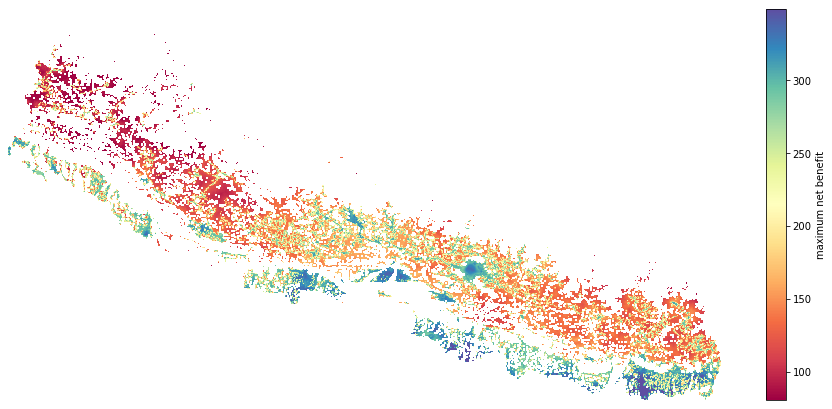

In [256]:
nepal.plot('maximum_net_benefit', cmap='Spectral', cumulative_count=[0.01, 0.99])

In [257]:
nepal.to_image('maximum_net_benefit', cmap='Spectral', cumulative_count=[0.01, 0.99])

In [258]:
nepal.to_image('max_benefit_tech', cmap='Set2', legend_position=(0.7, 0.9))

In [ ]:
nepal.gdf.to_csv(os.path.join(output_directory, 'Output', 'sample_output.csv'))

In [ ]:
end = time.time()

diff = end - start
print('Execution time:', str(str(int(diff//60))) + ' min ' + str(int((diff)%60)) + ' sec')

In [ ]:
dff = nepal.gdf.groupby(['max_benefit_tech']).agg({'Calibrated_pop': lambda row: np.nansum(row) / 1000000,
                                                   'maximum_net_benefit': lambda row: np.nansum(row) / 1000000,
                                                   'investment_costs': lambda row: np.nansum(row) / 1000000}).reset_index()

In [ ]:
fig = px.pie(dff, names='max_benefit_tech', values='Calibrated_pop', color_discrete_sequence=['#dc0f0f', '#a86ee1', '#79de13'])
fig.write_image(os.path.join(output_directory, 'output', 'Pop_per_tech.pdf'), width=500, height=500)
fig.update_traces(textfont_size=16)
fig.show()

In [ ]:
fig = px.pie(dff, names='max_benefit_tech', values='investment_costs', color_discrete_sequence=['#dc0f0f', '#a86ee1', '#79de13'])
fig.write_image(os.path.join(output_directory, 'output', 'Investments.pdf'), width=500, height=500)
fig.update_traces(textfont_size=16)
fig.show()